In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import matplotlib.font_manager as font_manager
import json


 1. Scraping data from Understat website for multiple matches and parsing the shot data (X, Y, xG, result, etc.).

In [2]:
results = []

for m in range(2000, 2500):
    url = f'https://understat.com/match/{m}'
    try:
        req = requests.get(url)
        req.raise_for_status()
        soup = BeautifulSoup(req.content, 'lxml')
        scripts = soup.find_all('script')
        results.append(scripts)
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")



In [3]:
if len(scripts) > 1:
    script = scripts[1].string  
else:
    print(f"f: {m}")


In [4]:
start = script.index("('") + 2
end = script.index("')")
json_data = script[start:end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)


In [5]:
x = []
y = []
xG = []
result = []
team = []
result=[]
data_away = data['a']
data_home = data['h']

In [6]:
for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'X':
            x.append(data_home[index][key])
        if key == 'Y':
            y.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])



In [7]:

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'X':
            x.append(data_away[index][key])
        if key == 'Y':
            y.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])

In [8]:
print(f"Length of x: {len(x)}")
print(f"Length of y: {len(y)}")
print(f"Length of xG: {len(xG)}")
print(f"Length of team: {len(team)}")
totalshot=len(xG)


Length of x: 20
Length of y: 20
Length of xG: 20
Length of team: 20


2. Storing the parsed data into a DataFrame and converting coordinate percentages to actual field dimensions (in meters).

In [9]:

df = pd.DataFrame({
    'x': x,
    'y': y,
    'xG': xG,
    'team': team,
    'result':result
})

In [10]:
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['xG']=df['xG'].astype(float)
totalgoal=df[df['result']=='Goal']
totalgoal=totalgoal.shape[0]
totalXG=df['xG'].sum()
totalXG

2.091182508505881

In [11]:
# I saved the data in an Excel file to save time 
df = pd.read_excel(r'D:\ML\football_shot_data.xlsx')
df.head()

,x,y,xG,team,result
0,0.755,0.763,0.018577,Lorient,SavedShot
1,0.739,0.728,0.018621,Lorient,SavedShot
2,0.881,0.627,0.012981,Lorient,BlockedShot
3,0.879,0.638,0.040332,Lorient,SavedShot
4,0.880,0.483,0.073058,Lorient,BlockedShot


In [12]:

toatalshot=df['xG'].shape[0]
toatalshot
totalgoal=df[df['result']=='Goal']
totalgoal=totalgoal.shape[0]
totalXG=df['xG'].sum()
totalXG

486.27343523036666

In [13]:
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['xG'] = df['xG'].astype(float)


In [14]:
df['x']=df['x']*100
df['y']=df['y']*100


In [15]:
pitchlength = 105  
pitchwidth = 65    
goalw = 7.32
df['center']=abs(df['y']-50)

df.head()


,x,y,xG,team,result,center
0,75.500000,76.300003,0.018577,Lorient,SavedShot,26.300003
1,73.900002,72.800003,0.018621,Lorient,SavedShot,22.800003
2,88.099998,62.700001,0.012981,Lorient,BlockedShot,12.700001
3,87.900002,63.799999,0.040332,Lorient,SavedShot,13.799999
4,88.000000,48.299999,0.073058,Lorient,BlockedShot,1.700001


 3. Calculating additional metrics such as shooting angle and distance from goal for each shot.


In [16]:
# Define goal constants
GOAL_Y = 50  
GOAL_LINE_X = 100 

for i, row in df.iterrows():
    x = df.at[i, 'x'] * 105 / 100  
    y = df.at[i, 'y'] * 65 / 100   

    
    distance = np.sqrt((GOAL_LINE_X - df.at[i, 'x'])**2 + (df.at[i, 'y'] - GOAL_Y)**2)  
    df.at[i, 'Distance'] = distance

    


goal_left = np.array([100, 45])
goal_right = np.array([100, 55])

for i in range(len(df)):
    
    x = df.at[i, 'x']
    y = df.at[i, 'y']
    
   
    shot_position = np.array([x, y])
    
    vector_to_left_post = goal_left - shot_position
    vector_to_right_post = goal_right - shot_position
    
    cosine_angle = np.dot(vector_to_left_post, vector_to_right_post) / (np.linalg.norm(vector_to_left_post) * np.linalg.norm(vector_to_right_post))
    
    angle = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle)
    
    df.at[i, 'Angle'] = abs(angle_degrees)

df.head()



,x,y,xG,team,result,center,Distance,Angle
0,75.500000,76.300003,0.018577,Lorient,SavedShot,26.300003,35.943569,10.944724
1,73.900002,72.800003,0.018621,Lorient,SavedShot,22.800003,34.656169,12.512814
2,88.099998,62.700001,0.012981,Lorient,BlockedShot,12.700001,17.404024,23.181169
3,87.900002,63.799999,0.040332,Lorient,SavedShot,13.799999,18.353472,21.206606
4,88.000000,48.299999,0.073058,Lorient,BlockedShot,1.700001,12.119819,44.552330


In [17]:
df['G'] = df.apply(lambda row: 1 if row['result'] == 'Goal' else 0, axis=1)
df.head()

,x,y,xG,team,result,center,Distance,Angle,G
0,75.500000,76.300003,0.018577,Lorient,SavedShot,26.300003,35.943569,10.944724,0
1,73.900002,72.800003,0.018621,Lorient,SavedShot,22.800003,34.656169,12.512814,0
2,88.099998,62.700001,0.012981,Lorient,BlockedShot,12.700001,17.404024,23.181169,0
3,87.900002,63.799999,0.040332,Lorient,SavedShot,13.799999,18.353472,21.206606,0
4,88.000000,48.299999,0.073058,Lorient,BlockedShot,1.700001,12.119819,44.552330,0


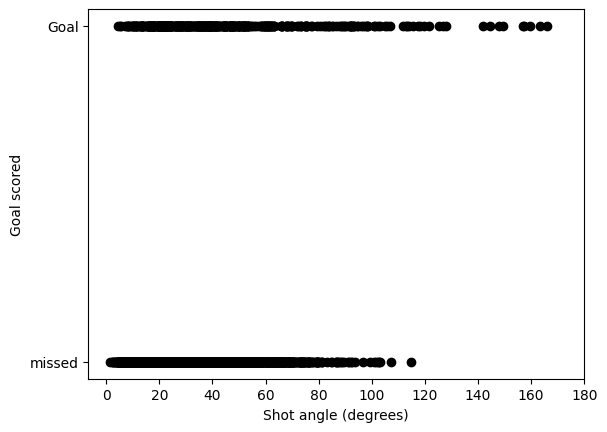

In [18]:
fig,ax=plt.subplots(num=1)
ax.plot(df['Angle'], df['G'], linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_xticks(range(0,190,20))
ax.set_yticklabels(['missed','Goal'])
plt.show()

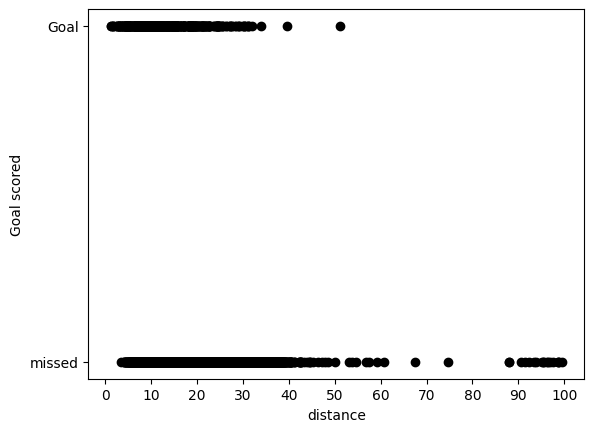

In [19]:
fig,ax=plt.subplots(num=1)
ax.plot(df['Distance'], df['G'], linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("distance")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_xticks(range(0,110,10))
ax.set_yticklabels(['missed','Goal'])
plt.show()

In [20]:
background_color = '#021526'  


font_path = r'C:\Users\Anas\Downloads\Arvo-Regular.ttf'
font_props = font_manager.FontProperties(fname=font_path)
c='#667BC6'


In [21]:
pitch = VerticalPitch(
    pitch_type='opta', 
    half=True, 
    pitch_color=background_color, 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)

In [22]:
x=df[['Angle','Distance']].values
y=df['G'].values



 4. Applying logistic regression to predict the probability of a shot being a goal based on shot angle and distance.


In [23]:
rate = 0.001  
iter = 1000   
n = x.shape[0] 
theta = np.zeros((1 + x.shape[1]))  

los = []  

for i in range(iter):
    ypred = theta[0] + np.dot(x, theta[1:])
    gy = 1 / (1 + np.exp(-ypred))

    
    cost = (-y * np.log(gy) - (1 - y) * np.log(1 - gy)).mean()
    los.append(cost)

    dthet0 = (1/n) * np.sum(gy - y)  
    dthet1 = (1/n) * np.dot(x.T, (gy - y))  

   
    theta[0] = theta[0] - rate * dthet0
    theta[1:] = theta[1:] - rate * dthet1



In [24]:
los

[0.6931471805599454,
 0.5583056886127048,
 0.49252900514257936,
 0.45602632152293815,
 0.43337548253604713,
 0.41801860682455994,
 0.4068345346852424,
 0.3981987856522193,
 0.39120584950552495,
 0.3853233345521661,
 0.38022462116655403,
 0.3757021868430976,
 0.371620162474238,
 0.36788715898586644,
 0.36444011129071524,
 0.3612343716506785,
 0.35823747892429586,
 0.35542515785596634,
 0.3527787072769101,
 0.3502832726900603,
 0.3479266923721097,
 0.3456987208945596,
 0.3435905038224912,
 0.3415942209120466,
 0.33970284289334884,
 0.33790996497133496,
 0.33620969210594454,
 0.33459655913099545,
 0.3330654741931077,
 0.33161167769659405,
 0.3302307114824692,
 0.3289183947159367,
 0.3276708041530858,
 0.32648425727225605,
 0.32535529730503354,
 0.3242806795674764,
 0.3232573587311064,
 0.3222824768256743,
 0.32135335185995817,
 0.3204674670025908,
 0.3196224602957607,
 0.3188161148898782,
 0.31804634979317425,
 0.3173112111307914,
 0.31660886390584875,
 0.3159375842518112,
 0.315295752162

In [25]:
# Apply sigmoid function to get the probabilities
prob = 1 / (1 + np.exp(-ypred))
for p in prob:
    if p > 0.5:
        print(p)


0.5019869998638475
0.5235522355869018
0.6150537228568247
0.5031739276899092
0.5427779548347593
0.5733459850523375
0.5142597265814122
0.525538865421194
0.5161321242429767
0.5889142360467807
0.5893466202156821
0.5585520798533953
0.5877029364198428
0.5014034820206177
0.517508172899611
0.5424876003725507
0.6135291745679096
0.5873640213214775


In [26]:
df['prob']=prob


In [27]:
print(prob.shape)

(4510,)


5. Creating visualizations using matplotlib and mplsoccer to show the xG map with shots, goals, and high/low-quality chances.


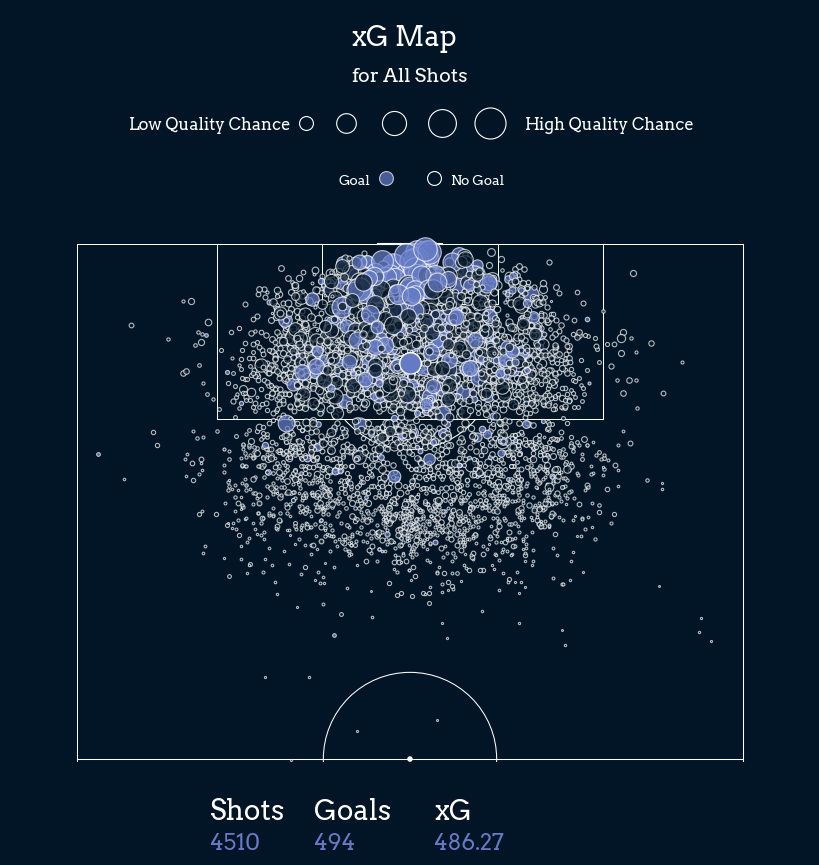

In [28]:
fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor(background_color)




ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)


ax1.text(
    x=0.5, 
    y=.85, 
    s='xG Map  ', 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='center'
)
ax1.text(
    x=0.5, 
    y=.7, 
    s=f'for All Shots', 
    fontsize=14,
    fontweight='bold',
    fontproperties=font_props, 
    color='white', 
    ha='center'
)
ax1.text(
    x=0.25, 
    y=0.5, 
    s=f'Low Quality Chance', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)

ax1.scatter(
    x=0.37, 
    y=0.53, 
    s=100, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)
ax1.scatter(
    x=0.42, 
    y=0.53, 
    s=200, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)
ax1.scatter(
    x=0.48, 
    y=0.53, 
    s=300, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)
ax1.scatter(
    x=0.54, 
    y=0.53, 
    s=400, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)
ax1.scatter(
    x=0.6, 
    y=0.53, 
    s=500, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)

ax1.text(
    x=0.75, 
    y=0.5, 
    s=f'High Quality Chance', 
    fontsize=12, 
    fontproperties=font_props, 
    color='white', 
    ha='center'
)


ax1.text(
    x=0.45, 
    y=0.27, 
    s=f'Goal', 
    fontsize=10, 
    fontproperties=font_props, 
    color='white', 
    ha='right'
)
ax1.scatter(
    x=0.47, 
    y=0.3, 
    s=100, 
    color=c, 
    edgecolor='white', 
    linewidth=.8,
    alpha=.7
)


ax1.scatter(
    x=0.53, 
    y=0.3, 
    s=100, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)

ax1.text(
    x=0.55, 
    y=0.27, 
    s=f'No Goal', 
    fontsize=10, 
    fontproperties=font_props, 
    color='white', 
    ha='left'
)

ax1.set_axis_off()


ax2 = fig.add_axes([.05, 0.25, .9, .5])
ax2.set_facecolor(background_color)

pitch.draw(ax=ax2)





for x in df.to_dict(orient='records'):
    pitch.scatter(
        x['x'], 
        x['y'], 
        s=300 * x['xG'], 
        color=c if x['result'] == 'Goal' else background_color, 
        ax=ax2,
        alpha=.7,
        linewidth=.8,
        edgecolor='white'
    )
    
ax2.set_axis_off()

ax3 = fig.add_axes([0, .2, 1, .05])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

ax3.text(
    x=0.25, 
    y=.5, 
    s='Shots', 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='left'
)

ax3.text(
    x=0.25, 
    y=0, 
    s=f'{toatalshot}', 
    fontsize=16, 
    fontproperties=font_props, 
    color=c, 
    ha='left'
)

ax3.text(
    x=0.38, 
    y=.5, 
    s='Goals', 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='left'
)

ax3.text(
    x=0.38, 
    y=0, 
    s=f'{totalgoal}', 
    fontsize=16, 
    fontproperties=font_props, 
    color=c, 
    ha='left'
)

ax3.text(
    x=0.53, 
    y=.5, 
    s='xG', 
    fontsize=20, 
    fontproperties=font_props, 
    fontweight='bold', 
    color='white', 
    ha='left'
)

ax3.text(
    x=0.53, 
    y=0, 
    s=f'{totalXG:.2f}', 
    fontsize=16, 
    fontproperties=font_props, 
    color=c, 
    ha='left'
)





ax3.set_axis_off()
